In [170]:
import numpy as np
from scipy.signal import correlate, welch, freqz
import scipy.signal as signal
from scipy.io import wavfile as wav
import scipy.linalg as linalg
import matplotlib.pyplot as plt
from scipy.fft import fft
from arch.unitroot import ADF, PhillipsPerron, KPSS
from scipy.interpolate import interp1d
from scipy.signal import butter, lfilter
import scipy.io.wavfile
from IPython.display import Audio
from pydub import AudioSegment
import scipy.signal as sps
from statsmodels.tsa.filters.filtertools import recursive_filter

In [171]:
def EsEstacionario(signal, alpha):
  #PhillipsPerron Test
  phpr_result = PhillipsPerron(signal)
  phpr_p_value = phpr_result.pvalue
  phpr_test_result = "Stationary" if phpr_p_value < alpha else "Not stationary"
  print("PhillipsPerron Test:", phpr_test_result)
  # Augmented Dickey-Fuller Test
  adf_result = ADF(signal)
  adf_p_value = adf_result.pvalue
  adf_test_result = "Stationary" if adf_p_value < alpha else "Not stationary"
  print("Augmented Dickey-Fuller Test:", adf_test_result)
  # Kwiatkowski-Phillips-Schmidt-Shin Test
  kpss_result = KPSS(signal, lags=-1)
  kpss_p_value = kpss_result.pvalue
  kpss_test_result = "Stationary" if kpss_p_value > alpha else "Not stationary"
  print("Kwiatkowski-Phillips-Schmidt-Shin Test:", kpss_test_result)

In [172]:
# Carga el archivo WAV original
original_audio = AudioSegment.from_file("./a.wav")

# Define la frecuencia de muestreo deseada (16 kHz en este caso)
nueva_frecuencia = 16000

# Realiza el downsampling
audio_downsampled = original_audio.set_frame_rate(nueva_frecuencia)

# Guarda el audio downsampled en un nuevo archivo
audio_downsampled.export("./a_16khz.wav", format="wav")

# Carga el archivo WAV original
original_audio = AudioSegment.from_file("./sh.wav")

# Define la frecuencia de muestreo deseada (16 kHz en este caso)
nueva_frecuencia = 16000
audio_downsampled = original_audio.set_frame_rate(nueva_frecuencia)
audio_downsampled.export("./sh_16khz.wav", format="wav")


<_io.BufferedRandom name='./sh_16khz.wav'>

Se evalua si el sistema es estacionario. Se trató de que la grabación sea lo más estable posible, pero se trató de asegurarse que lo fuera. 

In [173]:
#Valor significativo: 
alpha = 0.05
#95% de confianza
a_sr, signal_a = wav.read("./a_16khz.wav")
signal_a_aux = signal_a.ravel()
sh_sr, signal_sh = wav.read("./sh_16khz.wav")
signal_sh_aux = signal_sh.ravel()


# Convertir a mono
a_mono = np.mean(signal_a, axis=1)
sh_mono =  np.mean(signal_sh, axis=1)

a_mono = a_mono - np.mean(a_mono)
a_mono = a_mono / np.abs(np.argmax(a_mono))
a_mono = a_mono[1*16000:2*16000]
sh_mono = sh_mono - np.mean(sh_mono)
sh_mono = sh_mono / np.abs(np.argmax(sh_mono))
sh_mono = sh_mono[1*16000:2*16000]



In [174]:
EsEstacionario(signal_a_aux/np.max(abs(signal_a)), alpha)

PhillipsPerron Test: Stationary
Augmented Dickey-Fuller Test: Stationary
Kwiatkowski-Phillips-Schmidt-Shin Test: Stationary


In [175]:
EsEstacionario(signal_sh_aux/np.max(abs(signal_sh)), alpha)

PhillipsPerron Test: Stationary
Augmented Dickey-Fuller Test: Stationary
Kwiatkowski-Phillips-Schmidt-Shin Test: Not stationary


# Eda de las señales 


Realizamos espectrogramas de las señales para verificar visualmente su estabilidad y las componentes de frecuencia principales. 

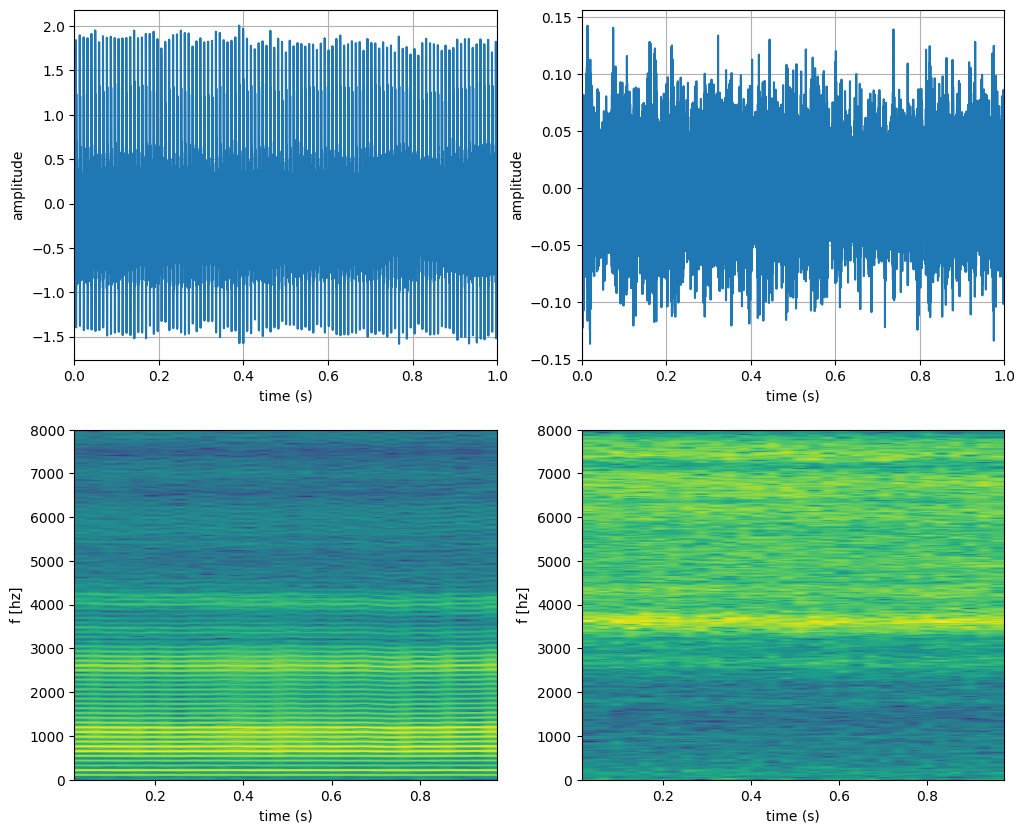

In [176]:
# Crear subgráficos
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plotear las señales
axs[0, 0].grid()
axs[0, 0].set_xlim(0, len(a_mono) / a_sr)
axs[0, 0].plot(np.arange(len(a_mono)) / a_sr, a_mono)
axs[0, 0].set_xlabel('time (s)')
axs[0,0].set_ylabel('amplitude')

axs[1, 0].specgram(a_mono, Fs=a_sr, cmap='viridis', NFFT=1024, noverlap=512)
axs[1,0].set_xlabel('time (s)')
axs[1,0].set_ylabel('f [hz]')
axs[0, 1].grid()
axs[0, 1].set_xlim(0, len(sh_mono) / sh_sr)
axs[0, 1].plot(np.arange(len(sh_mono)) / sh_sr, sh_mono)
axs[0, 1].set_xlabel('time (s)')
axs[0,1].set_ylabel('amplitude')
axs[1, 1].specgram(sh_mono, Fs=sh_sr, cmap='viridis', NFFT=1024, noverlap=512)
axs[1,1].set_xlabel('time (s)')
axs[1,1].set_ylabel('f [hz]')
plt.show()

In [177]:
signal_a = a_mono
signal_sh = sh_mono

Se procede a evaluar el error forward para diferentes órdenes de filtro. Es notorio que en el caso del fonema /sh/ el gráfico contiene solo un codo (aprox. en M=25),
mientras que para el fonema /a/ resulta haber dos (M=35 y M=160).

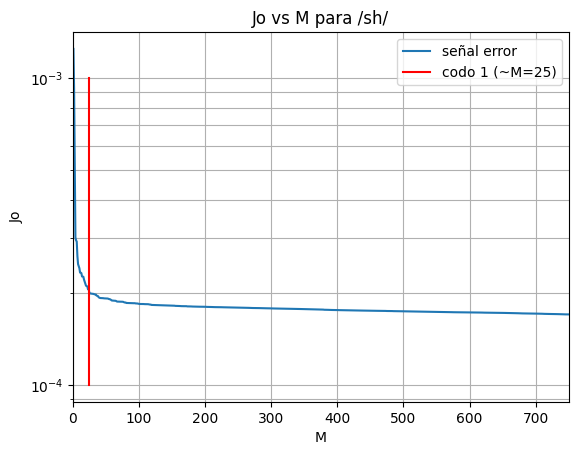

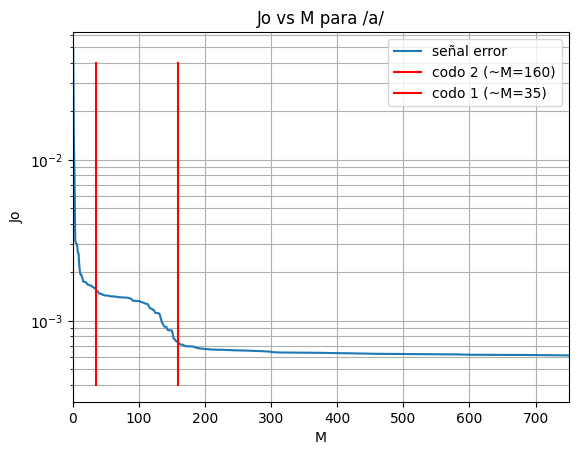

In [178]:
m_array = [i for i in range(1,1500)]
#m_array = [int(x) for x in (np.logspace(0, 4.2, num = 1000))]
N = len(signal_sh)
r = correlate(signal_sh, signal_sh, 'full')[len(signal_sh)-1:] / len(signal_sh)
Jo_sh_array = []
a0_sh_array = []
for m in m_array:
    r_forward = np.conjugate(r[1:m+1]) 
    a0 = linalg.solve_toeplitz(r[:m], -1*r_forward)
    jo = r[0] + np.dot(r[1:m+1], np.transpose(a0))
    Jo_sh_array.append(jo)
    a0_sh_array.append(a0)

plt.title('Jo vs M para /sh/')
plt.xlabel('M')
plt.ylabel('Jo')
plt.xlim(0,750)
plt.grid(which='both')
plt.semilogy(m_array, Jo_sh_array,label = 'señal error')
plt.plot([25, 25], [1e-4,0.1e-2], 'r-', label = 'codo 1 (~M=25)')
plt.legend()
plt.show()

m_array = [i for i in range(1,2000)]
#m_array = [int(x) for x in (np.logspace(0, 4.2, num = 1000))]
N = len(signal_a)
r = correlate(signal_a, signal_a, 'full')[len(signal_a)-1:] / len(signal_a)
Jo_a_array = []
a0_a_array = []
for m in m_array:
    r_forward = np.conj(r[1:m+1]) 
    a0 = linalg.solve_toeplitz(r[:m], -1*r_forward)
    jo = r[0] + np.dot(r[1:m+1], np.transpose(a0))
    Jo_a_array.append(jo)
    a0_a_array.append(a0)

plt.title('Jo vs M para /a/')
plt.xlabel('M')
plt.ylabel('Jo')
plt.xlim(0,750)
plt.grid(which='both')
plt.semilogy(m_array, Jo_a_array,label = 'señal error')
plt.plot([160, 160], [4e-4,4e-2], 'r-', label = 'codo 2 (~M=160)')
plt.plot([35, 35], [4e-4,4e-2], 'r-', label = 'codo 1 (~M=35)')
plt.legend()
plt.show()

Investigando la señal correspondiente a /a/ notamos ciertas cuestiones. Primero, observando la PSD se puede notar que la señal /a/ contiene componentes periódicas. Esto es una diferencia respecto de la señal /sh/. Es evidente que cuando se entona el fonema /a/ debe haber un armónico principal seguido de una serie de armónicos sumado a acoplado a cierto nivel de ruido y que el fonema /sh/ tiene un comportamiento únicamente ruidoso. Esto se evidencia en los espectrogramas realizados. 

A continuación se muestran los periodogramas de las dos señales. Y son notorias tres cosas: 

1. El armónico principal de nuestra señal /a/ se encuentra aproximadamente en 150hz.  
2. El segundo codo (M~160) tienene una extensión que se corresponde con este armónico principal.
3. El primer codo (M~35) se corresponde con el punto a partir del cual aparece un nivel de energía no asociado al los armónicos.

Luego, observamos en la señal /sh/ el mismo fenómeno, donde el codo de ubica en el límite con la energía acumulada a altas frecuencias del que se compone la señal. 


<Figure size 600x200 with 0 Axes>

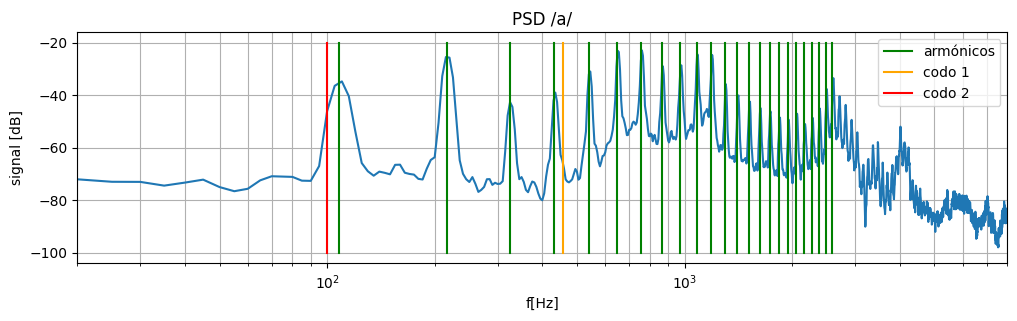

<Figure size 600x200 with 0 Axes>

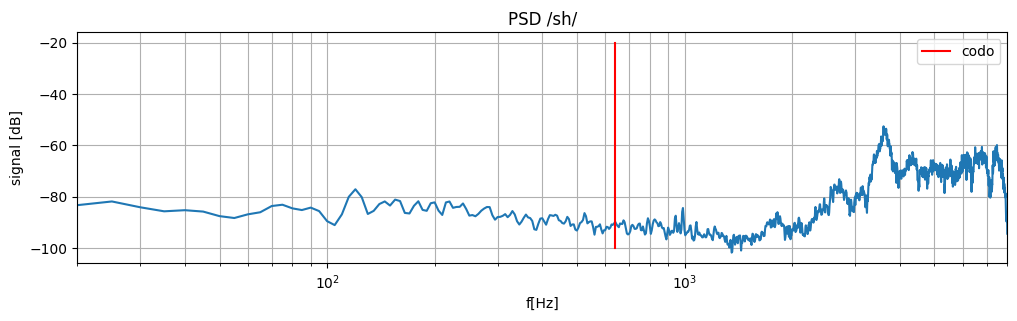

In [179]:
plt.figure(figsize=(6,2))
segnum = 5
f, Pxx_den = welch(signal_a, fs=16000, window='parzen', nperseg=len(signal_a)//segnum, noverlap=len(signal_a)//segnum//2, detrend='constant', return_onesided=True, scaling='density')

plt.figure(figsize=(12,3))
plt.semilogx(f, 10*np.log10(Pxx_den))
plt.title('PSD /a/')
plt.xlabel('f[Hz]')
plt.ylabel('signal [dB]')
plt.xlim(20,8000)
plt.grid(which='both')
codo1 = [16000/35, 16000/35]
armonicos = np.array([16000/148, 16000/148])

for i in range(1,25):
    if i==1:    
        plt.plot(i*armonicos, [-100, -20], 'g', label='armónicos')
    else:
        plt.plot(i*armonicos, [-100, -20], 'g')

plt.plot(codo1, [-100, -20], 'orange', label = 'codo 1')
plt.plot([16000/160, 16000/160], [-100, -20], 'r', label = 'codo 2')

plt.legend()
plt.show()

plt.figure(figsize=(6,2))
segnum = 5
f, Pxx_den = welch(signal_sh, fs=16000, window='parzen', nperseg=len(signal_a)//segnum, noverlap=len(signal_a)//segnum//2, detrend='constant', return_onesided=True, scaling='density')

plt.figure(figsize=(12,3))
plt.semilogx(f, 10*np.log10(Pxx_den))
plt.title('PSD /sh/')
plt.xlabel('f[Hz]')
plt.ylabel('signal [dB]')
plt.xlim(20,8000)
plt.grid(which='both')
codo1 = [16000/25, 16000/25]

plt.plot(codo1, [-100, -20], 'r', label = 'codo')


plt.legend()
plt.show()

Es decir, a medida que M crece el filtro puede incorporar información de frecuencias cada vez más bajas de la señal, que deja de estar en el error. Cuando M es 1, la PSD del error, lógicamente, es prácticamente igual a la señal de entrada.

A medida que M aumenta, las componentes de mayor frecuencia comienzan a desaparecer de la misma. Luego del primer codo, la energía acumulada en frecuencias medias del error disminuye ya que la longitud del filtro permite incormporar esa información en el filtrado y pasando el segundo codo también desaparecen los primeros armónicos. Este comportamiento explica la naturaleza de los dos codos de Jo.

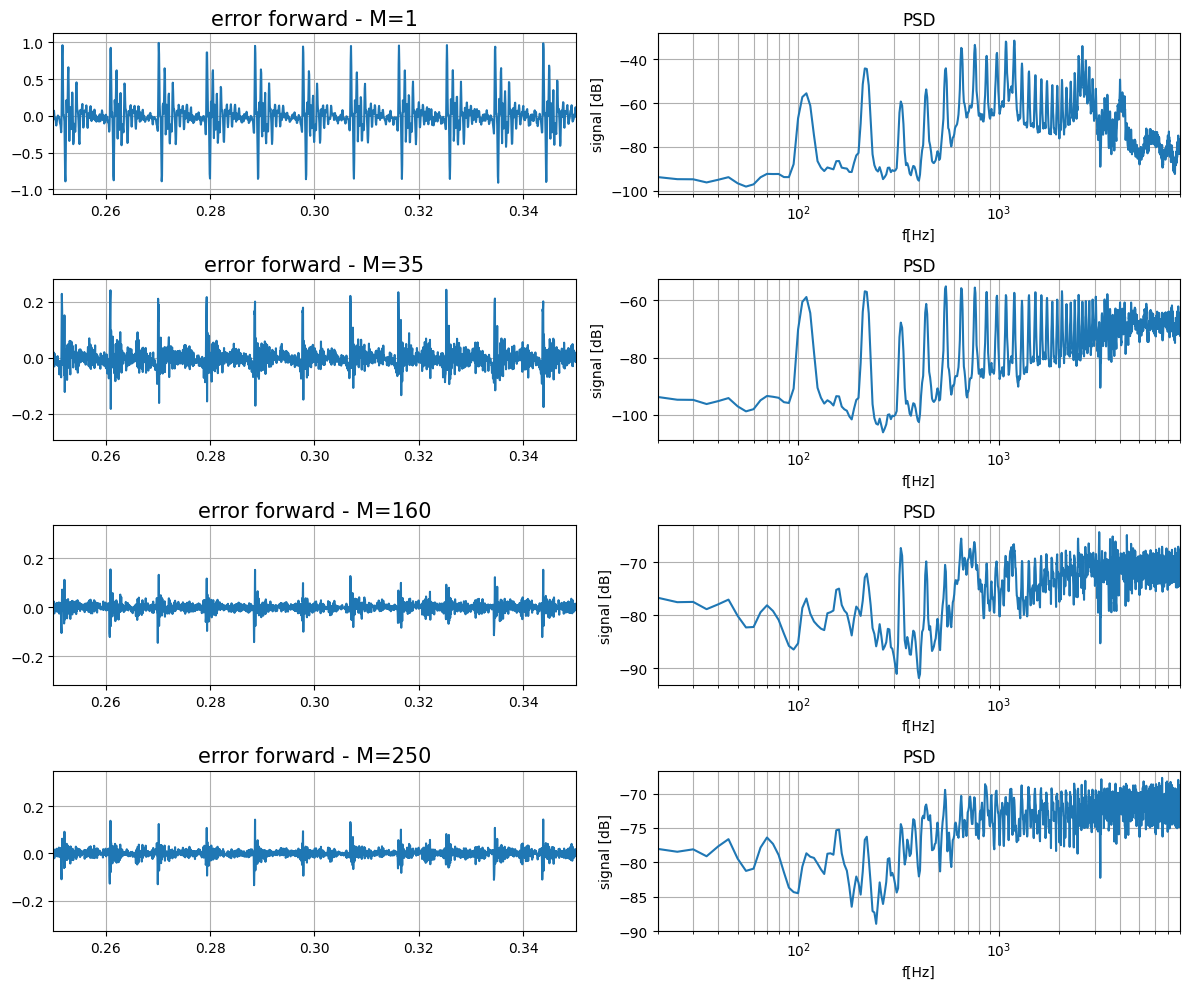

In [180]:
def analyze_e_f(i, ax, M = 250):
    a_error = np.concatenate(([1], a0_a_array[M-1]))
    error_forward = np.convolve(signal_a, a_error, mode='full')[:len(signal_a)]

    ax[i, 0].set_title('error forward - M=' + str(M), fontsize=15)
    ax[i, 0].plot(np.arange(len(error_forward))/16000,error_forward)
    ax[i, 0].set_xlim(0.25,0.35)
    ax[i, 0].grid(which='both')

    segnum = 5
    f, Pxx_den = welch(error_forward, fs=16000, window='parzen', nperseg=len(error_forward)//segnum, noverlap=len(error_forward)//segnum//2, detrend='constant', return_onesided=True, scaling='density')


    ax[i, 1].semilogx(f, 10*np.log10(Pxx_den))
    ax[i, 1].set_title('PSD')
    ax[i, 1].set_xlabel('f[Hz]')
    ax[i, 1].set_ylabel('signal [dB]')
    ax[i, 1].set_xlim(20,8000)
    ax[i, 1].grid(which='both')
    return i+1

m_arr = [1,35, 160, 250]
i = 0
fig, ax = plt.subplots(len(m_arr), 2, figsize=(12, 10))  # Create a 2x2 grid of subplots and select the first one
for m in m_arr:
    i = analyze_e_f(i, ax, m)
fig.tight_layout()
plt.show()

# Punto 3

Para las grabaciones del punto 1, representen la respuesta en frecuencia H(ejω)
del filtro del error de predicción ā (no el filtro predictor a) para M = 1, 2, 4, 8, 16,
32, 64. Expliquen y justifiquen los resultados obtenidos, teniendo en cuenta J(M)
y ef
(n).

In [181]:
m_array = [1, 2, 4, 8, 16, 32, 64]

a_arr_a = [np.concatenate(([1],a0_a_array[1-1])),
         np.concatenate(([1],a0_a_array[2-1])),
         np.concatenate(([1],a0_a_array[4-1])),
         np.concatenate(([1],a0_a_array[8-1])),
         np.concatenate(([1],a0_a_array[16-1])),
         np.concatenate(([1],a0_a_array[32-1])),
         np.concatenate(([1],a0_a_array[64-1]))]

a_arr_sh = [np.concatenate(([1],a0_sh_array[1-1])),
            np.concatenate(([1],a0_sh_array[2-1])),
            np.concatenate(([1],a0_sh_array[4-1])),
            np.concatenate(([1],a0_sh_array[8-1])),
            np.concatenate(([1],a0_sh_array[16-1])),
            np.concatenate(([1],a0_sh_array[32-1])),
            np.concatenate(([1],a0_sh_array[64-1]))]




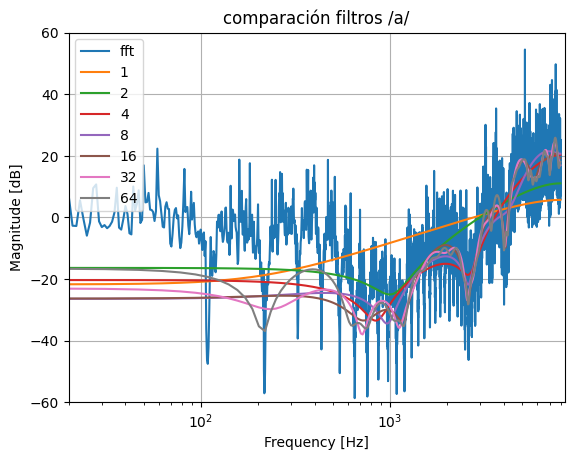

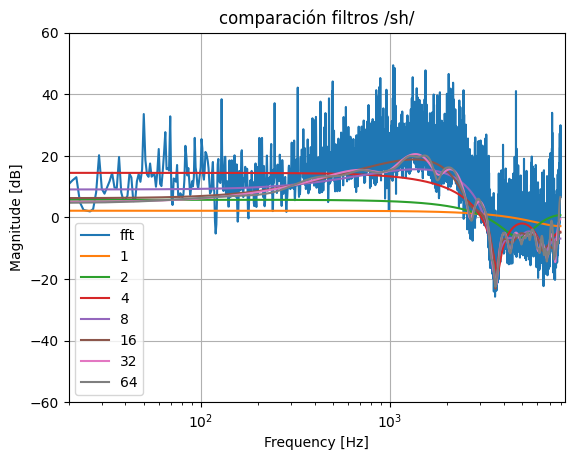

In [182]:
#Señal a

win = signal.get_window('parzen', len(signal_sh))
fft_result = np.fft.fft(win*signal_a)

frequencies = np.fft.fftfreq(len(fft_result), 1/16000)
frequencies = frequencies[:len(frequencies)//2-1]
fft_result = fft_result[:len(fft_result)//2-1:]
plt.plot(frequencies, 20 * np.log10(np.abs(1/fft_result)), label= 'fft')
plt.xlim(20,)
plt.ylim(-60,60)

for i, a in enumerate(a_arr_a):
    w, h = freqz(a, fs = 16000)
    plt.plot(w, 20 * np.log10(np.abs(h)), label= str(m_array[i]))


plt.title('comparación filtros /a/')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')
plt.grid()
plt.semilogx()
plt.legend()
plt.show()

#Señal sh

win = signal.get_window('parzen', len(signal_sh))

fft_result = np.fft.fft(win*signal_sh)

frequencies = np.fft.fftfreq(len(fft_result), 1/16000)
frequencies = frequencies[:len(frequencies)//2-1]
fft_result = fft_result[:len(fft_result)//2-1:]
plt.plot(frequencies, 20 * np.log10(np.abs(1/fft_result)), label= 'fft')
plt.xlim(20,)
plt.ylim(-60,60)

for i, a in enumerate(a_arr_sh):
    w, h = freqz(a, fs = 16000)
    plt.plot(w, 20 * np.log10(np.abs(h)), label= str(m_array[i]))


plt.title('comparación filtros /sh/')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')
plt.grid()
plt.semilogx()
plt.legend()
plt.show()

# Punto 4

A continuación se modela la señal error para un filtro de M = 35 como un modelo AR de orden 250. Elegimos este modelo siguiendo las recomendaciones dadas en clase. El orden permite mostrar  Para hacer esto se resuelven las ecuaciones de Yule Walker para el mismo, y luego se filtra la señal error con el filtro inverso al filtro error. Consideramos que nuestro modelado es apropiado si se obtiene una señal semejante al audio de /a/ original. Y, efectivamente, analizando los periodogramas del audio original y la síntesis a partir de ruido blanco, se observa una gran similitud entre los mismos. 

16000 16000


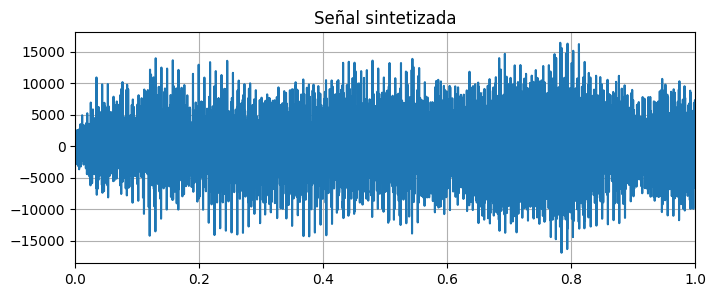

In [183]:
#Para la señal de error utilizamos un M de orden 25, para que quede despues del 1er codo

M = 35
a_aux = a0_a_array[M]
a_error = np.concatenate(([1], a_aux))
error_forward = sps.lfilter(a_error, [1], signal_a)

# Sacamos la autocorrelación del error
error_forward_corr = correlate(error_forward, error_forward, method='fft', mode='same')[len(error_forward)//2:] / (len(error_forward))

# Usamos un modelo de orden 350 para poder capturar los armónicos más bajos de la señal ruido 
ar_order = 250

# Resolvemos las ecuaciones de Yule Walker
R = error_forward_corr[:ar_order]
r = error_forward_corr[1:ar_order+1]
a_ar = linalg.solve_toeplitz(R, r)

# Sintetizamos un simil de la señal de error a partir de ruido blanco
# llamamos a esta señal sintetizada como synthetic error
synthetic_error = signal.lfilter([1], np.concatenate(([1], -a_ar)), np.random.normal(size=len(signal_a)))

#Hacemos el filtrado inverso de la señal de error sintetizada
synthetic_signal = sps.lfilter([1], a_error, synthetic_error) 

#normalizamos la señal generada para el wav
synthetic_signal = np.int16(synthetic_signal*32767/(2*np.max(synthetic_signal)))
signal_a_normalized = np.int16(signal_a*32767/(2*np.max(signal_a)))

print(len(synthetic_signal), len(signal_a_normalized))
# Plotear las señales
plt.figure(figsize=(8, 3))
plt.grid(which='both')
plt.title('Señal sintetizada')
plt.xlim(0, len(synthetic_signal) / a_sr)
plt.plot(np.arange(len(synthetic_signal)) / a_sr, synthetic_signal)
plt.show()



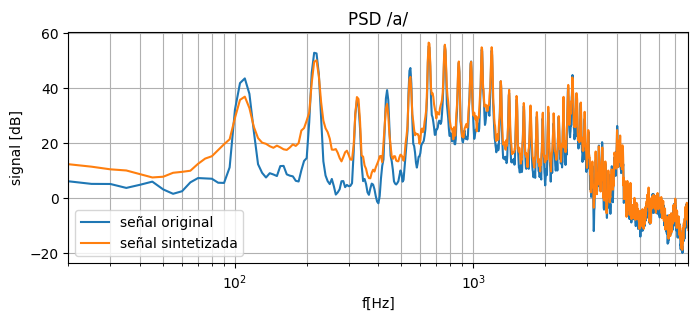

In [184]:
segnum = 5
f_synth, Pxx_den_synth = welch(synthetic_signal, fs=16000, window='parzen', nperseg=len(synthetic_signal)//segnum, noverlap=len(synthetic_signal)//segnum//2, detrend='constant', return_onesided=True, scaling='density')
f_original, Pxx_den_original = welch(signal_a_normalized, fs=16000, window='parzen', nperseg=len(signal_a_normalized)//segnum, noverlap=len(signal_a_normalized)//segnum//2, detrend='constant', return_onesided=True, scaling='density')

plt.figure(figsize=(8, 3))
plt.title('PSD /a/')
plt.xlabel('f[Hz]')
plt.ylabel('signal [dB]')
plt.xlim(20,8000)
plt.grid(which='both')
plt.semilogx(f_original, 10*np.log10(Pxx_den_original), label='señal original')
plt.semilogx(f_synth, 10*np.log10(Pxx_den_synth), label='señal sintetizada')
plt.legend()
plt.show()

Los audios resultantes de la síntesis del error y del filtrado inverso son los siguientes:

In [185]:
from IPython.display import Audio
from scipy.io import wavfile
wavfile.write('./RESINTETIZADO_AV2.wav', 16000, synthetic_signal)
Audio('./RESINTETIZADO_AV2.wav')

In [186]:
wavfile.write('./1sfragment.wav', 16000, signal_a)
Audio('./1sfragment.wav')

punto 4 alternativo

In [187]:
M = 12
a_aux = a0_a_array[M]
a_error = np.concatenate(([1], a_aux))
error_forward = sps.lfilter(a_error, [1], signal_a) #[len(signal_a):]
new_sig = sps.lfilter([1], a_error, signal_a) # error_forward)


wavfile.write('./RESINTETIZADO_AV3.wav', 16000, np.int16(new_sig*32767/(2*np.max(new_sig))))
print('audio filtrado y refiltrado: ')
Audio('./RESINTETIZADO_AV3.wav')

audio filtrado y refiltrado: 


In [188]:
print('audio original: ')
Audio('./a.wav')

audio original: 


# Punto 5

In [189]:
# Cargamos el archivo WAV original
original_audio = AudioSegment.from_file("./test.wav")

# Definimos la frecuencia de muestreo deseada (16 kHz en este caso)
nueva_frecuencia = 16000

# Realizamos el downsampling
audio_downsampled = original_audio.set_frame_rate(nueva_frecuencia)

# Guardamos el audio downsampleado en un nuevo archivo
audio_downsampled.export("./test_16khz.wav", format="wav")

<_io.BufferedRandom name='./test_16khz.wav'>

In [190]:
ds_sr, discurso = wav.read("./test_16khz.wav")
discurso = discurso - np.mean(discurso)
discurso = discurso / np.abs(np.argmax(discurso))
discurso = np.mean(discurso, axis=1)

In [191]:
# Definir la longitud de la ventana y el overlap
ventana_longitud = int(ds_sr * 0.05)  # 50 ms en muestras (fs es la frecuencia de muestreo)

overlap = ventana_longitud // 2  # 50% de superposición
senal_final = np.zeros(len(discurso))
# Definir el orden de predicción M
M = 25
# Frecuencia del tren de impulsos
fs_impulsos = 160  # Hz
impulsos = [1 if (j%100==0) else 0 for j in range(len(discurso))]
# Crear una ventana de Hann
ventana = np.hanning(ventana_longitud)
# Iterar sobre los bloques de señal con superposición
for i in range(0, len(discurso) - ventana_longitud, ventana_longitud - overlap):

    bloque_signal = discurso[i:i + ventana_longitud] 
    bloque_signal *= ventana
    r = correlate(bloque_signal, bloque_signal, 'full')[len(bloque_signal)-1:] / len(bloque_signal)
    r_forward = np.conj(r[1:M]) 
    a0 = linalg.solve_toeplitz(r[:M-1], -1*r_forward)
    a_error = np.concatenate(([1], a0[:M])) 

    bloque_error = sps.lfilter([1], a_error, impulsos[i:i+ventana_longitud]) # * ventana

    senal_final[i:i + ventana_longitud] += bloque_error

wavfile.write('./discurso_sintetizado.wav', 16000, np.int16(senal_final*32767/(np.max(senal_final))))
Audio('./discurso_sintetizado.wav')

In [192]:
Audio('./discurso_16khz.wav')